## Урок 3

### Практическое задание

### Теоретическая часть

1. Вспомним прошлый вебинар, мы рассматривали User-User рекомендации и Item-Item рекомендации. Чем они отличаются и чем они похожи? Если есть функция item_item_rec(interaction_matrix). Можно ли использовать эту функцию для user_user_rec? 


- User-User ищет для каждого клиента группу наиболее похожих на него (в терминах предыдущих покупок) клиентов и усредняет их предпочтения. Эти усредненные предпочтения и служат рекомендациями для пользователя. В случае же с Item-Item ближайшие соседи ищутся на множестве товаров — столбцов матрицы предпочтений. И усреднение происходит именно по ним.


Преимущества Item-based перед User-based:

- Когда пользователей много (почти всегда), задача поиска ближайшего соседа становится плохо вычислимой. Например, для 1 млн пользователей нужно рассчитать и хранить$\frac{1}{2}10^6*10^6$~ 500 млрд расстояний. Если расстояние кодировать 8 байтами, это получается 4TB для одной только матрицы расстояний. Если мы делаем Item-Item, то сложность вычислений снижается с $O(N^2n)$  до $O(n^2N)$, а матрица расстояний имеет размерность уже не (1 млн на 1 млн) а, например, (100 на 100) по количеству товаров.
- Оценка близости товаров гораздо более точная, чем оценка близости пользователей. Это прямое следствие того, что пользователей обычно намного больше, чем товаров и следовательно стандартная ошибка при расчете корреляции товаров там существенно меньше. У нас просто больше информации, чтобы сделать вывод.
- В user-based варианте описания пользователей, как правило, сильно разрежены (товаров много, оценок мало). С одной стороны это помогает оптимизировать расчет — мы перемножаем только те элементы, где есть пересечение. Но с другой стороны — сколько соседей не бери, список товаров, которые в итоге можно порекомендовать, получается очень небольшим.
- Предпочтения пользователя могут меняться со временем, но описание товаров штука гораздо более устойчивая.

В остальном алгоритм почти полностью повторяет User-User вариант: то же косинусное расстояние как основная мера близости, та же необходимость нормализации данных. Число соседних товаров N обычно выбирают в районе 20.

- Можно использовать функцию item_item_rec(interaction_matrix) для user_user_rec. Для этого нужно траспонировать (interaction_matrix)

В чем принципиальные отличия item-item рекомендаций от ALS?

- ALS - лишь способ оптимизации (поиска коэффициентов в эмбеддингах)

2. Приведите 3 примера весов (те, которых не было на вебинаре: сумма покупок, количество покупок - неинтересно) user-item матрицы для задачи рекомендаций товаров 


- Частота покупок товара;

- Размер среднего чека за период времени (например - неделя);

- ...(sorry, фантазия закончилась)


3. Какие ограничения есть у ALS? (Тип информации, линейность/нелинейность факторов и т д)


- Линейность
- Учитывает только положительные взаимодействия

4. Мы рассматривали bm_25_weight. 
Опишите, как он работает. Как сделать рекомендации только на основе bm_25? (Можно и нужно пользоваться любыми источниками, приложите на них ссылки). Какие еще способы перевзвешивания user-item матрицы Вы знаете / можете предложить (ещё 2-3 способа)?


- BM25 – функция расчета текстовой релевантности документов. Основана на эмпирических данных при попытке улучшить результаты работы критерия TF-IDF. Наилучшее соответствие между ожидаемым результатом и рассчитанным показал 25 алгоритм в списке, за что и получил свое название «Best matching», или BM25. Впервые был реализован в поисковой системе Okapi (Окапи), а в дальнейшем –  положен в основу текстовых анализаторов современных поисковых машин.<br>При увеличении вхождений ключевого слова в документ пропорционально увеличивается значение TF. Таким образом, добавление вхождений ключевых слов на страницу значительно повышает ее релевантность. Функция BM25 должна была устранить этот недостаток. В функцию БМ25 внедрены свободные коэффициенты, которые могут принимать различные значения. Они подбираются так, чтобы «подогнать» результат работы поиска под заранее имеющиеся данные. Документы сначала оценивают асессоры, которые и говорят что плохо, а что хорошо. Затем на основании этих данных выбирают упомянутые коэффициенты, чтобы расположить документы так же, как это сделали асессоры – так называемый «принцип обезьянки».<br>Источник - http://webline.blog/algoritm-okapi-bm25-modifikacziya-formuly-tf-idf-ranzhirovaniya-dokumentov/ 

### Практическая часть


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import seaborn as sns

from scipy.sparse import csr_matrix, coo_matrix

from implicit.nearest_neighbours import bm25_weight, tfidf_weight

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [3]:
data = pd.read_csv('../data/retail_train.csv')
data

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0


In [4]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result['actual'] = result['actual'].apply(lambda x: list(x))
result.head(10)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884..."
7,14,"[840601, 867293, 933067, 951590, 952408, 96569..."
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13..."
9,16,"[1062973, 1082185, 13007710]"


In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

/home/nicolay/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [7]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 
user_item_matrix = user_item_matrix.astype(float) 

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

### Подбор матрицы $c_{ui}$
Попробуйте различные варианты матрицы весов (3+ вариантов). Обучите алгоритм для различных $C$. В качестве результата приведите таблицу: матрица весов - результат на train и validation.
Сделате качественные выводы.


In [9]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 8.82 s, sys: 60.2 ms, total: 8.89 s
Wall time: 1.67 s


In [10]:
[id_to_itemid[rec[0]] for rec in recs]

[5569230, 1133018, 1106523, 1068719, 1033142]

In [11]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [12]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

CPU times: user 1min 33s, sys: 1.36 s, total: 1min 35s
Wall time: 15.9 s


In [13]:
result

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1033142, 995242, 965766, 979707, 1005186]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1133018, 1106523, 910032, 951590, 5568378]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[999999, 1082185, 878996, 1024306, 1007195]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[999999, 826249, 1082185, 938700, 1127831]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[6534178, 1068719, 1133018, 1053690, 1106523]"
...,...,...,...
2037,2496,[6534178],"[914190, 6534178, 916122, 1043301, 1133018]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[5569230, 951590, 866211, 1029743, 904360]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1053690, 9526410, 5568378, 999999, 916381]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[6534178, 1004906, 1053690, 883404, 866211]"


In [14]:
result.apply(lambda x: precision_at_k(x['als'], x['actual'], 5), axis=1).mean()

0.1824681684622892

In [27]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='sales_value',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 
user_item_matrix = user_item_matrix.astype(float) 

sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [29]:
%%time

model = AlternatingLeastSquares(factors=100, #k
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 8.15 s, sys: 67.9 ms, total: 8.22 s
Wall time: 1.52 s


In [30]:
[id_to_itemid[rec[0]] for rec in recs]

[1133018, 5569230, 1053690, 1068719, 913785]

In [31]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [34]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result['actual'] = result['actual'].apply(lambda x: list(x))
result.head(10)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884..."
7,14,"[840601, 867293, 933067, 951590, 952408, 96569..."
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13..."
9,16,"[1062973, 1082185, 13007710]"


In [35]:
%%time
    
result['als_s'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

CPU times: user 1min 32s, sys: 1.4 s, total: 1min 33s
Wall time: 15.6 s


In [36]:
result

,user_id,actual,als_s
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[995242, 1033142, 979707, 1082185, 962568]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[910032, 5568378, 1133018, 1106523, 9337581]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[999999, 1082185, 878996, 5569230, 1024306]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[999999, 826249, 1082185, 1127831, 1013321]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1068719, 844179, 6534178, 1053690, 1106523]"
...,...,...,...
2037,2496,[6534178],"[914190, 1044078, 1133018, 1006184, 995965]"
2038,2497,"[1016709, 9835695, 1132298, 16809501, 845294, ...","[951590, 5569230, 1098066, 866211, 854852]"
2039,2498,"[15716530, 834484, 901776, 914190, 958382, 972...","[1053690, 916381, 840361, 5568378, 859075]"
2040,2499,"[867188, 877580, 902396, 914190, 951590, 95813...","[6534178, 1098066, 994928, 826249, 883404]"


In [37]:
result.apply(lambda x: precision_at_k(x['als_s'], x['actual'], 5), axis=1).mean()

AttributeError: 'list' object has no attribute 'tocsr'

### Оптимизация гипперпараметров
Для лучшей матрицы весов из первого задания подберите оптимальные $\lambda$ и n_factors. Подбор можно делать вручную (цикл в цикле, аналог sklearn.GridSearch, или случайно - sklearn.RandomSearch). Или Вы можете воспользоваться библиотеками для автоматического подбора гипперпараметров (любые на Ваш вкус). В качестве результата постройте графики:
1. Значение параметра - время обучения 
2. Значение параметра - качество train, качество validation  

Сделайте качественные выводы

In [15]:
import time
def exec_time(start, end):
    diff_time = end - start
    return diff_time

In [16]:
factors = [50, 100, 300, 1000]
regularisation_coefs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

In [17]:
tfidf_matrix = tfidf_weight(user_item_matrix.T).T

In [18]:

%%time
statistic_dict = {}
for factor in factors:
    for reg_coef in regularisation_coefs:
        start = time.time()
        model_asl_tfidf = AlternatingLeastSquares(factors=factor,
                                                  regularization=reg_coef)
        model_asl_tfidf.fit(csr_matrix(tfidf_matrix).T.tocsr(),
          show_progress=False)

        result[f'als_tfidf_factors{factor}_regularization{reg_coef}'] = result['user_id'].\
            apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                            model_asl_tfidf.recommend(userid=userid_to_id[x], 
                                            user_items=sparse_user_item,
                                            N=5, 
                                            filter_already_liked_items=False, 
                                            filter_items=[itemid_to_id[999999]], 
                                            recalculate_user=True)])
        end = time.time()
        check_time = exec_time(start, end)
        result[f'precision@5_als_tfidf_factors{factor}_regularization{reg_coef}_recs'] = \
        result[[f'als_tfidf_factors{factor}_regularization{reg_coef}', \
                'actual']].apply(lambda x: precis_at_k(*x), axis=1)
        cur_prec = result[f'precision@5_als_tfidf_factors{factor}_regularization{reg_coef}_recs'].mean() * 100
        statistic_dict[f'precision@5_als_tfidf_factors{factor}_regularization{reg_coef}_recs'] = \
        (check_time, cur_prec, factor, reg_coef)

CPU times: user 5h 33min 7s, sys: 4min 12s, total: 5h 37min 20s
Wall time: 1h 25min 15s


In [19]:
result_df = pd.DataFrame(list(statistic_dict.items()),
             columns=['Параметры', 'Значения'])

In [20]:
result_df = result_df['Значения'].apply((pd.Series))

In [21]:
result_df.rename(columns={0: 'time, sec', 1: 'precision@5', 2: 'factors', 3: 'regularization coeff'}, inplace=True)

In [22]:
result_df.head(2)

,"time, sec",precision@5,factors,regularization coeff
0,10.407178,21.194907,50.0,0.001
1,10.677528,21.684623,50.0,0.005


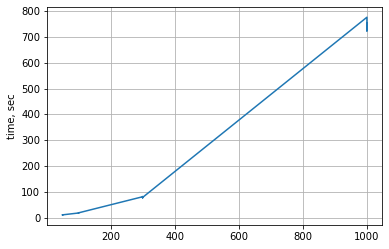

In [23]:
plt.plot(result_df['factors'], result_df['time, sec'])
plt.ylabel('time, sec')
plt.grid()
plt.show()

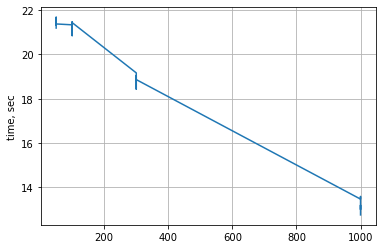

In [24]:
plt.plot(result_df['factors'], result_df['precision@5'])
plt.ylabel('time, sec')
plt.grid()
plt.show()

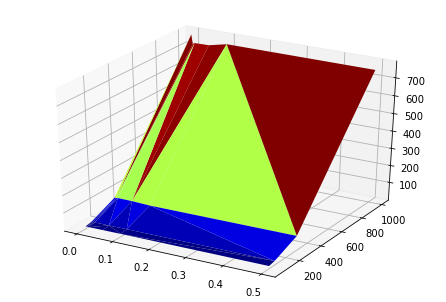

In [25]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(result_df['regularization coeff'],
                result_df['factors'],
                result_df['time, sec'],
                cmap=cm.jet,
                linewidth=0.2)
plt.show()

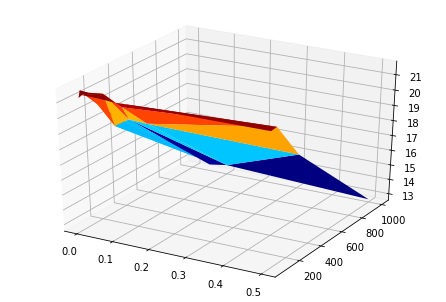

In [26]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(result_df['regularization coeff'],
                result_df['factors'],
                result_df['precision@5'],
                cmap=cm.jet,
                linewidth=0.2)
plt.show()

Как видно из графиков завимость времени выполнения от значения factors значительно увеличивается, при это точность растёт только до определённого момента, после чего начинает резко падать.

В нашей задаче коэффициент регуляризации практически не влияет ни на время, ни на точность.